# Practice Session PS05: Recommendation engines (Content-based)

For this assignment we will build and use a content-based recommender system for movies. This content-based recommender will take as input a database of users and ratings on movies.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

Author: <font color="blue">Your name here</font>

E-mail: <font color="blue">Your e-mail here</font>

Date: <font color="blue">The current date here</font>

# 0. The Movies dataset

One of the most widely used datasets for video/movies recommendation is the one built by the University of Minnesota, known as the [MovieLens DataSet](https://grouplens.org/datasets/movielens/). In this assignment we are going to use the 25M version, which was released in late 2019.

We will use a sub-set containing only movies released in the 2000s, and only 20% of the users and all of their ratings.

**MOVIES** are described in `movies-2000s.csv` in the following format: `movieId,title,genres`.

- Titles include the year of release in paranthesis, the year is greater or equal to 2000
- Genres are pipe-separated ("|") and are selected from the following genres: 'Musical', 'Horror', 'Comedy', 'Crime', 'Western', 'Sci-Fi', 'Documentary', 'Adventure', 'IMAX', 'Drama', 'Fantasy', 'Children', 'War', 'Thriller', 'Mystery', 'Action', 'Romance', 'Film-Noir', 'Animation' or '(no genres listed)'.

**RATINGS** are contained in `ratings-2000s.csv` in the following format: `userId,movieId,rating,timestamp`

- Ratings are made on a 5-star scale
- Timestamp is represented in seconds since the epoch as returned by time(2).
- This has been filtered to contain only movies released in the 2000s, and to sample 20% of rows

**TAGS** are contained in `tags-2000s.csv` in the following format: `userId,movieId,tag,timestamp`

- Tags are words or short phrases, they are user-generated and can be anything

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [ ]:
import pandas as pd   
import numpy as np  
import re
import matplotlib.pyplot as plt  
from math import*
import seaborn as sns
import wordcloud
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# 1. Load and join the dataset

The following code, which you should leave as-is, loads the 3 dataset within three dataframes named `movies`,  `ratings` and `tags` considering the data structure explained above.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [ ]:
# Leave this code as-is

FILENAME_MOVIES = "movies-2000s.csv"
FILENAME_RATINGS = "ratings-2000s.csv"
FILENAME_TAGS = "tags.csv"


In [ ]:
# Leave this code as-is

movies = pd.read_csv(FILENAME_MOVIES, 
                    sep=',', 
                    engine='python', 
                    encoding='latin-1',
                    names=['movie_id', 'title', 'genres'])
display(movies.head(5))

ratings_raw = pd.read_csv(FILENAME_RATINGS, 
                    sep=',', 
                    encoding='latin-1',
                    engine='python',
                    names=['user_id', 'movie_id', 'rating', 'timestamp'])
display(ratings_raw.head(5))

Next we will add a column named "year" to the `movies` dataset.

First, create a function `yearof()` that returns the year of a title as an integer, for instance:

```python
print(yearof("The Emoji Movie (2017)"))
```

Should return the integer *2017*. Then, you can apply this function to the entire dataframe.

If you have a function named *f* that takes the column *a* of dataframe *df*, and produces a value you want to store in column *b* of the same dataframe, you can use:

```python
df['b'] = df.apply(lambda x: f(x['a']), axis=1)
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your own code to add a `year` column to the `movies` dataframe.</font>

Next we will join the dataframes into a single dataframe named "ratings". The equivalent of a database join is done with [pandas.merge](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) in Pandas, and it requires to identify common columns between the inputs that need to be joined. You can use:

```python
a = pd.merge(b, c, how='inner', on='...')
```

There the `on` parameter should indicate the name of the column in common between `b` and `c`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with a brief commentary indicating on which field you can join ratings_raw and users, and on which field you can join ratings_raw and movies.</font>

<font size="+1" color="red">Replace this cell with your own code to join the datasets into a single dataframe named "ratings". Your dataframe should have the following columns: user_id, movie_id, rating, timestamp, gender, age, occupation, zipcode, title, genres</font>

Create a function `find_movies` to easily find movies that contain a given keyword in its title. For instance `find_movies("Barcelona", movies)` should print:

```
movie_id: 60950, title: Vicky Cristina Barcelona (2008)
movie_id: 182911, title: Barcelona Christmas Night (2015)
```

*Tip:* to know if string *a* is contained in string *b*, you can ask `if a in b`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for find _movies</font>

# 2. Exploratory Data Analysis

## 2.1. "Ratings" variable

To have a clear understanding of the data, it is key to know the distribution of the main variables.
With the **.describe** function of Pandas, we can get a summary of the main statistics of a numeric variable:

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [ ]:
# Leave this code as-is
ratings['rating'].describe()

It is key to know how ratings are distributed. Generate a plot with the ditribution of the ratings. 

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to plot a histogram of ratings. Include in the x axis the rating (1, 2, 3, 4, or 5) and in the y axis the probability of having that rating. Remember to label both axes.</font>

<font size="+1" color="red">Replace this cell with a brief commentary on what you observe in the distribution of ratings.</font>

Now let us find out two extrema: movies with many good ratings and movies with many bad ratings.

For this, a good idea is to find create a different dataframe. For instance, you can create `good_ratings`, containing only the subset of rows of `ratings` that has *rating > 4.0*, and `bad_ratings` containing only the subset that has *rating < 2.0*.

Then, you just need to count what are the most frequent titles in `good_ratings`. There are many ways to do this, one is by using [value_counts](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) and [nlargest](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nlargest.html), but there are other ways.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with code to print the 10 movies with the most "good" ratings (i.e., ratings that are larger than 4.0), and the 10 movies with the most "bad" ratings (i.e., ratings than are smaller than 2.0)</font>

<font size="+1" color="red">Replace this cell with a brief commentary on what you observe in these lists.</font>

## 2.2. Genres distribution

Tipically, a movie genre (e.g., "musical", "action", "romance") is one of the most important descriptor for a movie recommendation engine: a basic assumption is that films in the same genre should have similar contents. Because of this, we have to know how this variable is, i.e. the values or categories, number or ratio of each categories, and so on.

Create a table indicating the list of all genres (column `movie['genres']` in this dataset).

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with code to list all genres in the dataset. Verify the list has 18 genres.</font>

Print a table listing the genres you see in this dataset, sorted from the most frequent to the least frequent. Notice that these frequencies may add up to more than the number of movies in the dataset, as a movie may have more than one genre.

Your output should look like this:

```python
[['Drama', 13666],
 ['Comedy', 8898],
 ['Thriller', 5437],
 ['Documentary', 4473],
 ['Action', 3901],
 ['Romance', 3846],
 ['Horror', 3431],
 ['Crime', 2425],
 ['(no genres listed)', 2200],
 ['Sci-Fi', 1907],
 ['Adventure', 1906],
 ['Children', 1639],
 ['Animation', 1553],
 ['Mystery', 1516],
 ['Fantasy', 1456],
 ['War', 679],
 ['Musical', 308],
 ['Western', 194],
 ['IMAX', 173],
 ['Film-Noir', 21]]
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with code to obtain the frequency of each genre, check that it returns the same result as above.</font>

Visualizing this data can help us better understand the distribution of genres. A useful visualization in some cases is a word cloud. We will use a [WordCloud Library](http://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html) by Andreas Mueller.

The next code generates a word cloud. You can leave as-is or optionally change colors/stype.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [ ]:
# Change the colors/style if you want

# Generate the word cloud
genre_wordcloud = WordCloud(width=1000, height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(dict(keyword_occurences))

# Plot the word cloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

<font size="+1" color="red">Produce two word clouds: one for movies filmed before 2010, and another for movies filmed after 2010, and compare them. Do you notice any difference?</font>

# 3. Content-based recommendation

A content-based recommender works with data that describes the movie (or content). In our case, we will mainly use the genres that describes each movie. Our assumption is that films in the same genres should have similar contents and therefore are more likely to be recommended.

We *could* extend the content-based taking into account the title or any other text-based characteristics of the movie. We could also extend it using other attributes of the movie, even if they are not text. Content-based recommendations just means that we somehow compute the similarity between the items and then recommend the most similar items.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

## 3.1. Compute TF-IDF vectors

**Term Frequency (TF)** and **Inverse Document Frequency (IDF)** are techniques used in information retrieval to determine the **importance** of a word. In our use case, content-based recommendation, TF-IDF will be used to measure the importance of each genre in each movie. 

TF is simply the frequency of a word in a document, IDF is the inverse of the document frequency among the whole corpus of documents. Usually, TF and IDF are combined to measure the relevance of a word or term across different documents.

In a nutshell, TF-IDF weights infrequent words (in our case genres) more heavily. This means that two movies that share many uncommon genres will be considered more similar than two movies that share many common genres.

The TF-IDF score is computed as:

**tfidf(keyword, document) = TF(keyword, document) x IDF(keyword)**

Where:

* **TF(keyword, doc)** is the number of times the *keyword* appears in the *document*
* **IDF(keyword)** is **log(N/docfreq(keyword))** where **N** is the total number of documents and **docfreq(keyword)** is the number of documents containing the **keyword**

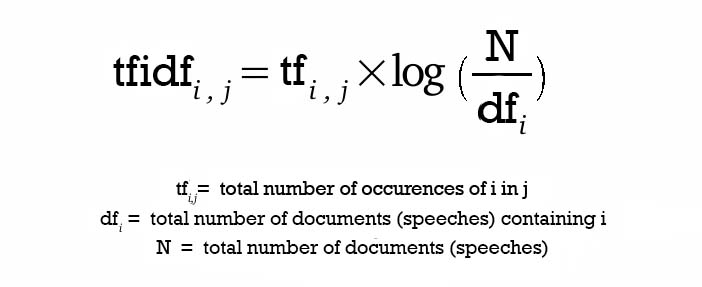

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

As a movie can belong to several genres, you should first break up the genre string into a string array.

Create a new column `genres_arr` in dataframe `movies` that contains the genres splitted in character "|".

Ensure this column has no "NaN", using [fillna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html). Example: `df['colname'].fillna('').astype('str')`

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code to add column "genres_arr" to the dataframe "movies".</font>

Verify by running the next cell. It should print:

```
Transformed: Adventure|Sci-Fi|Thriller → ['Adventure', 'Sci-Fi', 'Thriller']
```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [ ]:
# Leave this code as-is

print("Transformed: %s → %s" % (movies['genres'][2], movies['genres_arr'][2]))

Now we will work with a smaller part of the data. Define `movies_filtered` as all the movies filmed after 2015.

Use the [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to compute tf-idf vectors on this column. Use `ngram_range=(1,2)` to consider one- and two-word genres. Store the resulting vectors in `tfidf_matrix`.

The resulting matrix should have 7890 rows and 128 columns. Verify this using `tfidf_matrix.shape`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [ ]:
# LEAVE AS-IS

# The reset-index is important to match row/column numbers in the tdifd-matrix

movies_filtered = movies[movies.year > 2015]
movies_filtered = movies_filtered.reset_index()
display(movies_filtered.head(5))

<font size="+1" color="red">Replace this cell with your code to generate "tfidf_matrix"</font>

## 3.2. Calculate most similar movies

As previously explained, the calculated TF-IDF from **genre** will be the variable to describe the content; i.e. in our case, the movie. 
The **similarity** will be measured considering the angle between the vectors generated after the TF-IDF process. Each movie becomes a vector of attributes in an **n-dimensional space** where the angles between the vectors **determines the similarity**. 
The method of calculating this relative measure is taking the cosine of the angle between two vectors. The vectors are length normalized and then the cosine calculation is simply the sum-product of vectors. 

For a more generic perspective, the next image is an example of several sentences represented by its vector space where Sentence 2 is more likely to be using Term 2 than using Term 1.

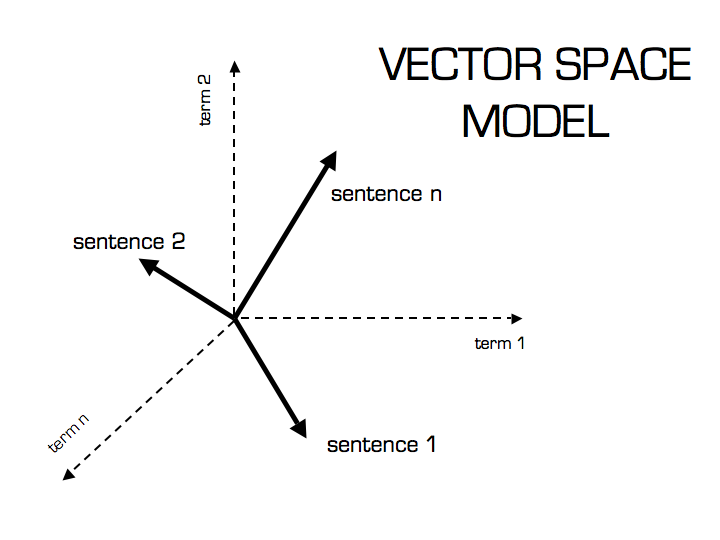

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

The next code, which you should leave as-is, uses sklearn's [linear_kernel](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.linear_kernel.html) function, which is a fast way of computing these similarities on a matrix.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [ ]:
# Leave this code as-is

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim)

It is easy at this point to confuse movie_ids with row numbers. The following code, which you should leave as-is, will be helpful to you as it shows you how to obtain a row/column in this similarity matrix, and then how to go back to movie_ids from row/column numbers.

In this example, we ask for the similarities of all movies to movie with id 1 which is "Toy Story (1995)".

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [ ]:
# Leave this code as-is

# Create an index to convert from numbers to movie_id
movie_id_to_index = pd.Series(movies_filtered.index, index=movies_filtered['movie_id'])

# Print the similarity vector
def print_similarity_vector(movie_id, similarities):
    
    # Determine the index of the movie_id
    index_source = movie_id_to_index[movie_id]
    
    # Get the row in the similarities matrix
    sim_scores = list(similarities[index_source])

    # Iterate through that row
    for index_target in range(len(sim_scores)):
        print("%.3f %d %s" %
              (sim_scores[index_target], movies_filtered.iloc[index_target].movie_id, movies_filtered.iloc[index_target].title))
        
print_similarity_vector(122904, cosine_sim)

Create a function `genre_content_based_recommendations` that uses the similarity matrix and the list of movie titles to find the top-k most recommended movies for a given movie.

Python's `enumerate` function will be helpful. Look at the following example:

```python
similarities = [0.2, 0.7, 0.3, 0.4]
enumerated = list(enumerate(similarities))
sorted_similarities = sorted(enumerated, key=lambda x: x[1], reverse=True)
top_two_similarities = sorted_similarities[0:2]
for index, similarity in top_two_similarities:
    print("Element #%d with similarity %.1f" % (index, similarity))
```

The output will be: 

```
Element #1 with similarity 0.7
Element #3 with similarity 0.4
```

The function `genre_content_based_recommendations` should follow this template:

```python
def genre_content_based_recommendations(movie_id, movies, similarities, num_movies=10):

    index_source = movie_id_to_index[movie_id]
    
    # Replace this comment with code to produce top_similarities
    
    recommendations = []
    for (index_target, similarity) in top_similarities:
        
        # Replace this comment with code to obtain movie_id, title, genres
        
        recommendations.append({
                'movie_id': movie_id,
                'title': title,
                'genres': genres,
                'similarity': similarity
            }
        )
    
    return pd.DataFrame.from_records(recommendations, columns=['similarity', 'movie_id', 'title', 'genres'])

```

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code for "genre_content_based_recommendations"</font>

<font size="+1" color="red">Replace this cell with code to print the top 15 recommendations for movie "Deadpool" (movie_id=122904) and "Midsommer" (movie_id=201646).</font>

<font size="+1" color="red">Replace this cell with code to get the list of recommendation for three movies you are familiar with. Indicate the **precision** of each list, which is the percentage of recommended movies that *you* consider relevant (mark manually as "relevant" or "irrelevant" each recommendation). Indicate the **average precision** across the three lists.</font> 

<font size="+1" color="red">Replace this cell with ideas on how you would improve **this** content-based recommendations, based on what we discussed in class about content-based recommendations.</font>

# DELIVER (individually)

Remember to read the section on "delivering your code" in the [course evaluation guidelines](https://github.com/chatox/data-mining-course/blob/master/upf/upf-evaluation.md).

Deliver a zip file containing:

* This notebook

## Extra points available

For more learning and extra points, use the user-defined tags defined in the `tags-2000.csv` file, in the same way in which you used movie genres. Feel free to filter aggressively if necessary (e.g., to impose a minimum document frequency when doing the tf-idf vectorization).

**Note:** if you go for the extra points, add ``<font size="+2" color="blue">Additional results: tags</font>`` at the top of your notebook.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>